## MATH3041 Project
## Climate Model

### Importing and Compiling Data

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from ipywidgets import *
#%matplotlib notebook

#######################################################
########## Import/clean temperature data ##############
#######################################################
df_temp = pd.read_csv("Data/nasa_land-ocean_temp_index.txt", delim_whitespace=True)
df_temp['No_Smoothing'] = df_temp['No_Smoothing']+14.15
df_temp = df_temp[['Year','No_Smoothing']]
df_temp.columns = ['YEAR', 'TEMP']


#######################################################
#### Import/clean greenhouse gas concentration data ###
#######################################################
df_gg_1 = pd.read_csv("Data/ice_core_2006.txt", delim_whitespace=True)
df_gg_2 = pd.read_csv("Data/NOAA_MoleFractions_2022.csv")

df_gg_1 = df_gg_1[["YearAD", "CH4spl", "CO2spl","N2Ospl"]]
df_gg_2 = df_gg_2[["YEAR","CO2","CH4","N2O"]]
df_gg_2['YEAR'] = df_gg_2['YEAR']-0.5
df_gg_1.columns = ['YEAR', 'CH4', 'CO2', 'N2O']
#df_gg_1 ranges from 1-2004
#df_gg_2 ranges from 1979-2020
df_gg_2 = df_gg_2[df_gg_2['YEAR']>=2005]


#concat df_gg_2 from 2005 onwards onto the end of df_gg_1
df_gg = pd.concat([df_gg_1, df_gg_2], ignore_index=True)

# TODO: Maybe try averaging the values for the overlapping years since they aren't the same

co2_data = df_gg[['YEAR','CO2']]
ch4_data = df_gg[['YEAR','CH4']]
n2o_data = df_gg[['YEAR','N2O']]

#alternative numpy array approach
#co2_data = df_gg[['YEAR','CO2']].to_numpy()
#print(co2_data[:,0]) #years
#print(co2_data[:,1]) #values

### Define Climate Model Class and Greehouse Gas Classes

In [2]:
#tracks surface temp data, should be changed to track surface ocean and deep ocean temperature 
class climateModel:
    hcap = 51.0 #heat capacity
    climateFeedback = -1.3
    solconst = 1368.0
    albedo = 0.3
    startTime = 1850
    preindustTemp = 13.8
    temp = []
    time = []
    delta_t = 1
    
    #Can set all parameters, but uses above defaults
    def __init__(self, startTime=startTime, delta_t=delta_t, hcap=hcap, climateFeedback=climateFeedback, solconst=solconst, albedo=albedo, preindustTemp=preindustTemp, ggs=[]):
        self.hcap = hcap
        self.solconst = solconst
        self.albedo = albedo
        self.preindustTemp = preindustTemp
        self.climateFeedback = climateFeedback
        self.climateInter = self.solconst*(1 - self.albedo)/4 + self.climateFeedback*self.preindustTemp;
        self.ggs = ggs
        self.temp = [self.preindustTemp]
        self.time = [self.startTime]

class greenhouseGas:
    def __init__(self, forcingCoeff, c_0, data=[]):
        self.data = data
        self.forcingCoeff = forcingCoeff
        self.c_0 = c_0
    def forcing(self,time):
        pass

class carbonDioxide(greenhouseGas):
    name = "CO2"
    c_0 = 278.0 #initial concentration of co2 at 1850 i think?
    forcingCoeff = 5.35
    def __init__(self, forcingCoeff=forcingCoeff, c_0=c_0, data=pd.DataFrame([])):
        super().__init__(forcingCoeff, c_0, data)
    
    def forcing(self,time):
        #use real world data
        if not self.data.empty:
            c_curr = self.data[self.data['YEAR']==time]['CO2']
        #use cubic estimate if no data provided
        else:
            c_curr = self.c_0*(1 + ((time - 1850)/220)**3) #not sure about the 1850 stuff?
        return (self.forcingCoeff*math.log(c_curr/self.c_0))

def gg_interaction(m,n):
    return 0.47 * math.log(1 + 2.01*(10**(-5))*(m*n)**0.75 + 5.31*(10**(-15))*m*(m*n)**1.52)
    
class methane(greenhouseGas):
    name = "CH4"
    c_0 = 722.0 #initial concentration of ch4 at 1850 i think?
    cn_0 = 270.0 #initial concentration of n2o at 1850 i think?
    forcingCoeff = 0.036
    
    def __init__(self, forcingCoeff=forcingCoeff, c_0=c_0, cn_0=cn_0, data=pd.DataFrame([])):
        super().__init__(forcingCoeff, c_0, data)
        self.cn_0 = cn_0
    
    def forcing(self,time):
        if not self.data.empty:
            c_curr = self.data[self.data['YEAR']==time]['CH4']
        #use initial concentration if no data provided
        else:
            c_curr = c_0 
        return self.forcingCoeff*(math.sqrt(c_curr) - math.sqrt(self.c_0)) - (gg_interaction(c_curr,self.cn_0) - gg_interaction(self.c_0,self.cn_0))

class nitrousOxide(greenhouseGas):
    name = "N2O"
    c_0 = 270.0 #initial concentration of n2o at 1850 i think?
    cm_0 = 722.0 #initial concentration of ch4 at 1850 i think?
    forcingCoeff = 0.12
    
    def __init__(self, forcingCoeff=forcingCoeff, c_0=c_0, cm_0=cm_0, data=[]):
        super().__init__(forcingCoeff, c_0, data)
        self.cm_0 = cm_0
    
    def forcing(self,time):
        if not self.data.empty:
            c_curr = self.data[self.data['YEAR']==time]['N2O']
        #use initial concentration if no data provided
        else:
            c_curr = c_0 
        return self.forcingCoeff*(math.sqrt(c_curr) - math.sqrt(self.c_0)) - (gg_interaction(self.cm_0,c_curr) - gg_interaction(self.cm_0,self.c_0))

print("Classes compiled")

Classes compiled


### Define Functions to Run the Climate Simulation

In [3]:
def solar_energy_in(s, a):
    return s*(1 - a)/4

def energy_leaving_surface(T, A, B):
    return A - B * T

def volcanic_aerosol_reflection():
    return 0

def human_aerosol_reflection():
    return 0

def greenhouse_effect(ggs,time):
    ef = 0.0
    for g in ggs:
        ef = ef + g.forcing(time)
    return ef
            

def tendency(model):
    return (1/model.hcap) * (solar_energy_in(model.solconst, model.albedo) \
            - volcanic_aerosol_reflection() \
            - human_aerosol_reflection() \
            - energy_leaving_surface(model.temp[-1], model.climateInter, model.climateFeedback) \
            + greenhouse_effect(model.ggs, model.time[-1]))
    
def timeStep(model):
    model.temp.append(model.temp[-1] + model.delta_t*tendency(model))
    model.time.append(model.time[-1] + model.delta_t)

def runSimulation(model, end_year):
    while model.time[-1] < end_year:
        timeStep(model)
    print("Finished Simulation")
    print("Plotting Results")

### Run the Simulation and Plot Results

Finished Simulation
Plotting Results


<IPython.core.display.Javascript object>


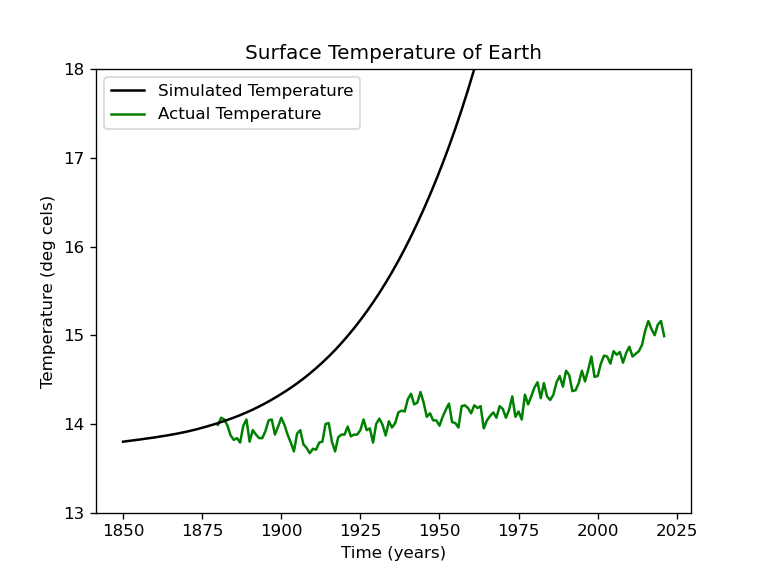

interactive(children=(FloatSlider(value=-1.3, description='Climate_feedback', max=4.0, min=-4.0), IntSlider(va…

<function __main__.update(Climate_feedback=-1.3, Heat_Capacity=51.0, CO2_Forcing=5.35, CH4_Forcing=0.036, N2O_Forcing=0.12)>

In [6]:
co2 = carbonDioxide(data=co2_data)
ch4 = methane(data=ch4_data)
n2o = nitrousOxide(data=n2o_data)

mod = climateModel(ggs=[co2,ch4,n2o])
runSimulation(mod, 2021)

# Interactive plot of temperature
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sim_line, = ax.plot(mod.time, mod.temp, color='k')
actual_temp, = ax.plot(df_temp['YEAR'].tolist(), df_temp['TEMP'].tolist(), color='g')
plt.title("Surface Temperature of Earth")
plt.xlabel("Time (years)")
plt.ylabel("Temperature (deg cels)")
plt.legend(["Simulated Temperature","Actual Temperature"])

def update(Climate_feedback=-1.3, Heat_Capacity=51.0, CO2_Forcing=5.35, CH4_Forcing=0.036, N2O_Forcing=0.12):
    co2u = carbonDioxide(data=co2_data, forcingCoeff=CO2_Forcing)
    ch4u = methane(data=ch4_data, forcingCoeff=CH4_Forcing)
    n2ou = nitrousOxide(data=n2o_data, forcingCoeff=N2O_Forcing)
    modu = climateModel(ggs=[co2u,ch4u,n2ou],climateFeedback=Climate_feedback, hcap=Heat_Capacity)
    runSimulation(modu, 2021)
    
    global sim_line
    sim_line.remove()
    sim_line, = ax.plot(modu.time, modu.temp, color='k')
    ax.set_ylim(13,18)

interact(update, Climate_feedback = (-4.0,4.0,0.1), Heat_Capacity = (1,100,1), CO2_Forcing = (0,20,0.1), CH4_Forcing=(0,5,0.001), N2O_Forcing=(0,5,0.01))
